In [1]:
import os
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torchaudio
import torch

from torch import nn
from torch.utils.data import DataLoader

import time

In [2]:
class ChordTypeDataset(Dataset):

    def __init__(self, annotations_file, audio_dir, transformation, target_sample_rate, num_samples, device):
        self.audio_dir = audio_dir
        self.device = device
        self.annotations = pd.read_csv(annotations_file)
        self.transformation = transformation.to(self.device)
        self.target_sample_rate = target_sample_rate
        self.num_samples = num_samples

    def __len__(self):
        return len(self.annotations)
        
    def __getitem__(self, index):
        audio_sample_path = self._get_audio_sample_path(index)
        label = self._get_audio_sample_label(index)
        signal, sample_rate = torchaudio.load(audio_sample_path)
        # Signal -> PyTorch Tensor (num_channels, samples)

        # Send signal to device (CUDA or CPU)
        signal = signal.to(self.device)
        
        # Make the audio signals have a uniform audio rate
        signal = self._resample(signal, sample_rate)
        # Make the audio mono
        signal = self._mixdown(signal)

        # Cut the audio to fit the necessary length
        signal = self._cut(signal)
        # Right pad the audio to fit the necessary length
        signal = self._right_pad(signal)

        
        signal = self.transformation(signal)
        return signal, label

    def _cut(self, signal):
        if signal.shape[1] > self.num_samples:
            signal = signal[:,:self.num_samples]
        return signal

    def _right_pad(self, signal):
        signal_length = signal.shape[1]
        if signal_length < self.num_samples:
            num_missing_samples = self.num_samples - signal_length
            end_padding = (0, num_missing_samples)
            signal = torch.nn.functional.pad(signal, end_padding)
        return signal

    def _resample(self, signal, original_sample_rate):
        # If the current sample rate is not the same as the target sample rate
        if original_sample_rate != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(original_sample_rate, self.target_sample_rate).to(self.device)
            signal = resampler(signal)
        return signal

    def _mixdown(self, signal):
        # If the audio is not already mono, make it mono
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdims=True)
        return signal

    def _get_audio_sample_path(self, index):
        path = os.path.join(self.audio_dir, self.annotations.iloc[index,1])
        return path

    def _get_audio_sample_label(self, index):
        return self.annotations.iloc[index,2]

In [3]:
class MyCNNNetwork(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # 4 convolutional blocks / flatten / linear / softmax

        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.flatten = nn.Flatten()
        self.linear = nn.Linear(128 * 5 * 9, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # #print(x.shape)
        # x = self.conv1(x)
        # #print(x.shape)
        # x = self.conv2(x)
        # #print(x.shape)
        # x = self.conv3(x)
        # #print(x.shape)
        # x = self.conv4(x)
        # #print(x.shape)
        # x = self.flatten(x)
        # #print(x.shape)
        # x = self.linear(x)
        # #print(x.shape)
        # predictions = self.softmax(x)
        # #print(predictions.shape)
        return self.softmax(self.linear(self.flatten(self.conv4(self.conv3(self.conv2(self.conv1(x)))))))

In [4]:
def train_step(model, data_loader, loss_function, optimiser, device):
    # Put the model in train mode
    model.train()

    train_loss, train_accuracy = 0, 0

    for batch, (X,y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)

        y_predicted = model(X)
        loss = loss_function(y_predicted, y)
        train_loss += loss.item()

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        y_predicted_class = torch.argmax(y_predicted, dim=1)
        train_accuracy += (y_predicted_class==y).sum().item()/len(y_predicted)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(data_loader)
    train_accuracy = train_accuracy / len(data_loader)
    return train_loss, train_accuracy

In [5]:
def test_step(model, data_loader, loss_function, optimiser, device):
    # Put the model in eval mode
    model.eval()

    test_loss, test_accuracy = 0, 0

    # Turn on inference mode:
    with torch.inference_mode():
        for batch, (X,y) in enumerate(data_loader):
            X, y = X.to(device), y.to(device)
    
            y_predicted = model(X)
            loss = loss_function(y_predicted, y)
            test_loss += loss.item()
    
            y_predicted_class = torch.argmax(y_predicted, dim=1)
            test_accuracy += (y_predicted_class==y).sum().item()/len(y_predicted)

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(data_loader)
    test_accuracy = test_accuracy / len(data_loader)
    return test_loss, test_accuracy

In [6]:
def train(model, train_data_loader, test_data_loader, loss_function, optimiser, device, epochs):
    results = {"train_loss": [], "train_accuracy": [], "test_loss": [], "test_accuracy": [], "epoch_time_train": [], "epoch_time_test": []}

    for epoch in range(epochs):
        torch.cuda.current_stream().synchronize()
        start = time.perf_counter()
        
        train_loss, train_accuracy = train_step(model, train_data_loader, loss_function, optimiser, device)

        torch.cuda.current_stream().synchronize()
        mid = time.perf_counter()
        
        test_loss, test_accuracy = test_step(model, test_data_loader, loss_function, optimiser, device)
        
        torch.cuda.current_stream().synchronize()
        end = time.perf_counter()

        epoch_time_train = (mid - start)
        epoch_time_test = (end - mid)
        
        
        #print(f"Epoch {epoch+1} | Train Loss {train_loss:.4f} | Train Accuracy {train_accuracy:.4f} | Test Loss {test_loss:.4f} | Test Accuracy {test_accuracy:.4f} | Elapsed Time {epoch_time:.4f}s")

        results["train_loss"].append(train_loss)
        results["train_accuracy"].append(train_accuracy)
        results["test_loss"].append(test_loss)
        results["test_accuracy"].append(test_accuracy)
        results["epoch_time_train"].append(epoch_time_train)
        results["epoch_time_test"].append(epoch_time_test)

    return results
        

In [7]:
# Performs the training loop and records the epoch times and total elapsed times for num_trials 
#(performs num_trials + 1, but drops the first trial result so that the GPU can "warm up" when being used)
def benchmark_chord_root_training(annotations_file, audio_dir, benchmark_device, num_trials, num_epochs, num_data_items, batchsize=32, learning_rate=1e-5, randomseed=13):
    results = {"elapsed_time": [], "epoch_time_train": [], "epoch_time_test": []}
    
    ANNOTATIONS_FILE = annotations_file
    AUDIO_DIR = audio_dir
    RAND_SEED = randomseed
    # Should be less than or equal to 86400
    NUM_DATA_ITEMS = num_data_items
    
    # Sample Rate should be 16000 Hz
    SAMPLE_RATE = 16000
    # Each item should be 4 seconds long
    NUM_SAMPLES = 4*SAMPLE_RATE
    
    # Additional Parameters
    EPOCHS = num_epochs
    LEARNING_RATE = learning_rate
    BATCH_SIZE = batchsize
    
    if torch.cuda.is_available():
        device = benchmark_device
    else:
        device = "cpu"
    
    print(f"Using device {device}")
    
    for i in range(num_trials + 1):
        print('Starting Trial ' + str(i))
        torch.manual_seed(RAND_SEED)
        torch.cuda.manual_seed(RAND_SEED)

        mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate=SAMPLE_RATE, n_fft=1024, hop_length=512, n_mels=64).to(device)

        # Number of data items should be <= 86400
        ctd, unused = torch.utils.data.random_split(ChordTypeDataset(ANNOTATIONS_FILE, AUDIO_DIR, mel_spectrogram, SAMPLE_RATE, NUM_SAMPLES, device), [NUM_DATA_ITEMS, 86400 - NUM_DATA_ITEMS])
    
        training_data, testing_data = torch.utils.data.random_split(ctd, [0.7, 0.3])
    
        # Create a data loader for the training set
        train_data_loader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
        test_data_loader = DataLoader(testing_data, batch_size=BATCH_SIZE, shuffle=False)
    
        # Create Network
        chord_classifier = MyCNNNetwork(12).to(device)
    
        # Instantiate Loss Function and Optimizer
        loss_function = nn.CrossEntropyLoss()
        optimiser = torch.optim.Adam(chord_classifier.parameters(), lr=LEARNING_RATE)
    
        torch.cuda.synchronize()
        start = time.perf_counter()
        trial_results = train(chord_classifier, train_data_loader, test_data_loader, loss_function, optimiser, device, EPOCHS)
        torch.cuda.synchronize()
        end = time.perf_counter()
    
        elapsed_time = (end - start)

        if i != 0:
            results['elapsed_time'].append(elapsed_time)
            results['epoch_time_train'].append(trial_results['epoch_time_train'])
            results['epoch_time_test'].append(trial_results['epoch_time_test'])

    return results

In [8]:
# Performs the training loop and records the epoch times and total elapsed times for num_trials 
#(performs num_trials + 1, but drops the first trial result so that the GPU can "warm up" when being used)
def benchmark_chord_type_training(annotations_file, audio_dir, benchmark_device, num_trials, num_epochs, num_data_items, batchsize=32, learning_rate=1e-5, randomseed=13):
    results = {"elapsed_time": [], "epoch_time_train": [], "epoch_time_test": []}
    
    ANNOTATIONS_FILE = annotations_file
    AUDIO_DIR = audio_dir
    RAND_SEED = randomseed
    # Should be less than or equal to 86400
    NUM_DATA_ITEMS = num_data_items
    
    # Sample Rate should be 16000 Hz
    SAMPLE_RATE = 16000
    # Each item should be 4 seconds long
    NUM_SAMPLES = 4*SAMPLE_RATE
    
    # Additional Parameters
    EPOCHS = num_epochs
    LEARNING_RATE = learning_rate
    BATCH_SIZE = batchsize
    
    if torch.cuda.is_available():
        device = benchmark_device
    else:
        device = "cpu"
    
    print(f"Using device {device}")
    
    for i in range(num_trials + 1):
        print('Starting Trial ' + str(i))
        torch.manual_seed(RAND_SEED)
        torch.cuda.manual_seed(RAND_SEED)

        mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate=SAMPLE_RATE, n_fft=1024, hop_length=512, n_mels=64).to(device)

        # Number of data items should be <= 86400
        ctd, unused = torch.utils.data.random_split(ChordTypeDataset(ANNOTATIONS_FILE, AUDIO_DIR, mel_spectrogram, SAMPLE_RATE, NUM_SAMPLES, device), [NUM_DATA_ITEMS, 86400 - NUM_DATA_ITEMS])
    
        training_data, testing_data = torch.utils.data.random_split(ctd, [0.7, 0.3])
    
        # Create a data loader for the training set
        train_data_loader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
        test_data_loader = DataLoader(testing_data, batch_size=BATCH_SIZE, shuffle=False)
    
        # Create Network
        chord_classifier = MyCNNNetwork(4).to(device)
    
        # Instantiate Loss Function and Optimizer
        loss_function = nn.CrossEntropyLoss()
        optimiser = torch.optim.Adam(chord_classifier.parameters(), lr=LEARNING_RATE)
    
        torch.cuda.synchronize()
        start = time.perf_counter()
        trial_results = train(chord_classifier, train_data_loader, test_data_loader, loss_function, optimiser, device, EPOCHS)
        torch.cuda.synchronize()
        end = time.perf_counter()
    
        elapsed_time = (end - start)

        if i != 0:
            results['elapsed_time'].append(elapsed_time)
            results['epoch_time_train'].append(trial_results['epoch_time_train'])
            results['epoch_time_test'].append(trial_results['epoch_time_test'])

    return results

In [9]:
# Perform Benchmarking
ROOT_ANNOTATIONS_FILE = 'C:/Users/indys/Desktop/Computer Science Software/Fall2024/Parallel/FinalProject/root.csv'
TYPE_ANNOTATIONS_FILE = 'C:/Users/indys/Desktop/Computer Science Software/Fall2024/Parallel/FinalProject/chord_type.csv'
AUDIO_DIR = 'C:/Users/indys/Desktop/Computer Science Software/Fall2024/Parallel/FinalProject/chordDataset'
num_trials = 5
num_epochs = 5
num_data_items_4096 = 4096
batchsize = 32

benchmark_device_gpu = 'cuda'

type_results_gpu_4096 = benchmark_chord_root_training(TYPE_ANNOTATIONS_FILE, AUDIO_DIR, benchmark_device_gpu, num_trials, num_epochs, num_data_items_4096, batchsize)

benchmark_device_cpu = 'cpu'

type_results_cpu_4096 = benchmark_chord_root_training(TYPE_ANNOTATIONS_FILE, AUDIO_DIR, benchmark_device_cpu, num_trials, num_epochs, num_data_items_4096, batchsize)

Using device cuda
Starting Trial 0
Starting Trial 1
Starting Trial 2
Starting Trial 3
Starting Trial 4
Starting Trial 5
Using device cpu
Starting Trial 0
Starting Trial 1
Starting Trial 2
Starting Trial 3
Starting Trial 4
Starting Trial 5


In [10]:
num_data_items_8192 = 8192

type_results_gpu_8192 = benchmark_chord_root_training(TYPE_ANNOTATIONS_FILE, AUDIO_DIR, benchmark_device_gpu, num_trials, num_epochs, num_data_items_8192, batchsize)

type_results_cpu_8192 = benchmark_chord_root_training(TYPE_ANNOTATIONS_FILE, AUDIO_DIR, benchmark_device_cpu, num_trials, num_epochs, num_data_items_8192, batchsize)

Using device cuda
Starting Trial 0
Starting Trial 1
Starting Trial 2
Starting Trial 3
Starting Trial 4
Starting Trial 5
Using device cpu
Starting Trial 0
Starting Trial 1
Starting Trial 2
Starting Trial 3
Starting Trial 4
Starting Trial 5


In [11]:
num_data_items_16384 = 16384

type_results_gpu_16384 = benchmark_chord_root_training(TYPE_ANNOTATIONS_FILE, AUDIO_DIR, benchmark_device_gpu, num_trials, num_epochs, num_data_items_16384, batchsize)

type_results_cpu_16384 = benchmark_chord_root_training(TYPE_ANNOTATIONS_FILE, AUDIO_DIR, benchmark_device_cpu, num_trials, num_epochs, num_data_items_16384, batchsize)

Using device cuda
Starting Trial 0
Starting Trial 1
Starting Trial 2
Starting Trial 3
Starting Trial 4
Starting Trial 5
Using device cpu
Starting Trial 0
Starting Trial 1
Starting Trial 2
Starting Trial 3
Starting Trial 4
Starting Trial 5


In [19]:
print(f'Chord Type Results (Subset Size {num_data_items_4096}):\n')
print(f"Trial/Device | GPU Train | CPU Train | GPU Test | CPU Test |")
for i in range(num_trials):
    print(f"     {i+1}       | {np.average(type_results_gpu_4096['epoch_time_train'][i]):.4f} | {np.average(type_results_cpu_4096['epoch_time_train'][i]):.4f} | {np.average(type_results_gpu_4096['epoch_time_test'][i]):.4f} | {np.average(type_results_cpu_4096['epoch_time_test'][i]):.4f} |")

Chord Type Results (Subset Size 4096):

Trial/Device | GPU Train | CPU Train | GPU Test | CPU Test |
     1       | 4.7119 | 10.4518 | 1.7478 | 2.6436 |
     2       | 4.7665 | 10.6183 | 1.7800 | 2.7240 |
     3       | 4.7991 | 11.2149 | 1.7798 | 2.7781 |
     4       | 4.7946 | 10.9964 | 1.7931 | 2.8069 |
     5       | 4.8317 | 10.3049 | 1.7938 | 2.5917 |


In [20]:
print(f'Chord Type Results (Subset Size {num_data_items_8192}):\n')
print(f"Trial/Device | GPU Train | CPU Train | GPU Test | CPU Test |")
for i in range(num_trials):
    print(f"     {i+1}       | {np.average(type_results_gpu_8192['epoch_time_train'][i]):.4f} | {np.average(type_results_cpu_8192['epoch_time_train'][i]):.4f} | {np.average(type_results_gpu_8192['epoch_time_test'][i]):.4f} | {np.average(type_results_cpu_8192['epoch_time_test'][i]):.4f} |")

Chord Type Results (Subset Size 8192):

Trial/Device | GPU Train | CPU Train | GPU Test | CPU Test |
     1       | 9.7752 | 19.6253 | 3.6991 | 5.2198 |
     2       | 9.9045 | 20.2630 | 3.5383 | 5.4081 |
     3       | 10.0638 | 20.5733 | 3.8818 | 5.4014 |
     4       | 10.1760 | 20.6922 | 4.1350 | 5.4339 |
     5       | 10.2084 | 20.0712 | 3.8994 | 5.3302 |


In [21]:
print(f'Chord Type Results (Subset Size {num_data_items_16384}):\n')
print(f"Trial/Device | GPU Train | CPU Train | GPU Test | CPU Test |")
for i in range(num_trials):
    print(f"     {i+1}       | {np.average(type_results_gpu_16384['epoch_time_train'][i]):.4f} | {np.average(type_results_cpu_16384['epoch_time_train'][i]):.4f} | {np.average(type_results_gpu_16384['epoch_time_test'][i]):.4f} | {np.average(type_results_cpu_16384['epoch_time_test'][i]):.4f} |")

Chord Type Results (Subset Size 16384):

Trial/Device | GPU Train | CPU Train | GPU Test | CPU Test |
     1       | 19.5169 | 40.4109 | 7.7995 | 10.4037 |
     2       | 19.4677 | 40.3710 | 7.9375 | 10.5222 |
     3       | 19.4545 | 40.5494 | 7.7952 | 10.3976 |
     4       | 19.5734 | 40.3926 | 7.7440 | 10.3600 |
     5       | 19.4931 | 40.4989 | 7.6865 | 10.3430 |


In [25]:
num_samples = [4096,8192,16384]

gpu_train_average_type = []
gpu_test_average_type = []
cpu_train_average_type = []
cpu_test_average_type = []


# Type Data

gpu_train_average_type.append(np.average(np.array(type_results_gpu_4096['epoch_time_train']).flatten()))
gpu_test_average_type.append(np.average(np.array(type_results_gpu_4096['epoch_time_test']).flatten()))
cpu_train_average_type.append(np.average(np.array(type_results_cpu_4096['epoch_time_train']).flatten()))
cpu_test_average_type.append(np.average(np.array(type_results_cpu_4096['epoch_time_test']).flatten()))

gpu_train_average_type.append(np.average(np.array(type_results_gpu_8192['epoch_time_train']).flatten()))
gpu_test_average_type.append(np.average(np.array(type_results_gpu_8192['epoch_time_test']).flatten()))
cpu_train_average_type.append(np.average(np.array(type_results_cpu_8192['epoch_time_train']).flatten()))
cpu_test_average_type.append(np.average(np.array(type_results_cpu_8192['epoch_time_test']).flatten()))

gpu_train_average_type.append(np.average(np.array(type_results_gpu_16384['epoch_time_train']).flatten()))
gpu_test_average_type.append(np.average(np.array(type_results_gpu_16384['epoch_time_test']).flatten()))
cpu_train_average_type.append(np.average(np.array(type_results_cpu_16384['epoch_time_train']).flatten()))
cpu_test_average_type.append(np.average(np.array(type_results_cpu_16384['epoch_time_test']).flatten()))



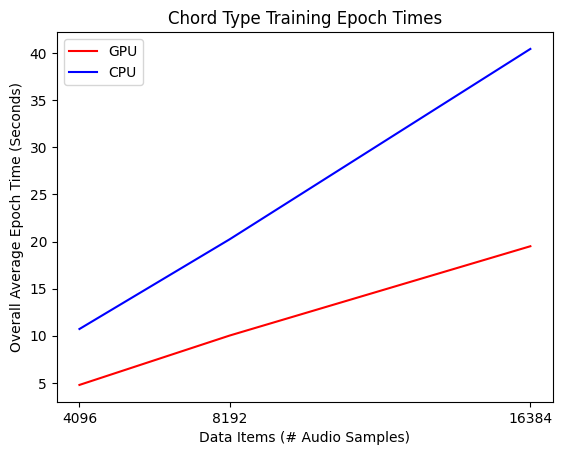

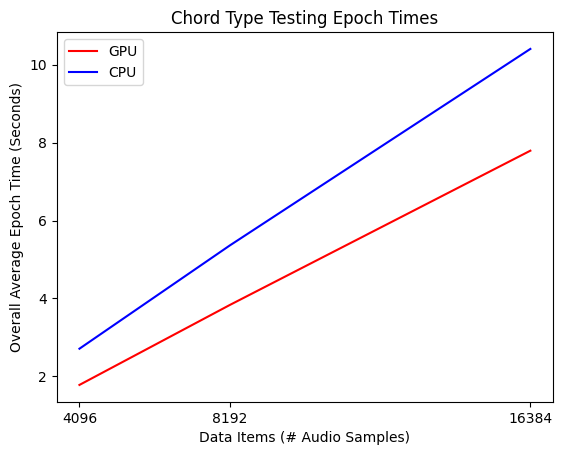

In [26]:
plt.plot(num_samples, gpu_train_average_type, c='r', label='GPU')
plt.plot(num_samples, cpu_train_average_type, c='b', label='CPU')
plt.title('Chord Type Training Epoch Times')
plt.xticks(num_samples)
plt.xlabel('Data Items (# Audio Samples)')
plt.ylabel('Overall Average Epoch Time (Seconds)')
plt.legend()
plt.show()

plt.plot(num_samples, gpu_test_average_type, c='r', label='GPU')
plt.plot(num_samples, cpu_test_average_type, c='b', label='CPU')
plt.title('Chord Type Testing Epoch Times')
plt.xticks(num_samples)
plt.xlabel('Data Items (# Audio Samples)')
plt.ylabel('Overall Average Epoch Time (Seconds)')
plt.legend()
plt.show()